In [10]:
# Basic setup: imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from ucimlrepo import fetch_ucirepo

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

ModuleNotFoundError: No module named 'numpy'

In [ ]:
# Fetching the data
wdbc = fetch_ucirepo(id=17)

# Quick checks of what we got
print("Dataset object type:", type(wdbc))
print("Dataset name:", wdbc.metadata.name)
print("Number of instances:", wdbc.metadata.num_instances)
print("Number of features:", wdbc.metadata.num_features)

Dataset object type: <class 'ucimlrepo.dotdict.dotdict'>
Dataset name: Breast Cancer Wisconsin (Diagnostic)
Number of instances: 569
Number of features: 30


In [18]:
import sys
print(sys.executable)  # should point to .venv/bin/python

/usr/local/opt/python@3.11/bin/python3.11


In [ ]:
x = wdbc.data.features
y = wdbc.data.targets
ids = wdbc.data.ids
print (ids.columns)

Index(['ID'], dtype='object')


In [ ]:
selected_columns_x = x[['texture1', 'area3', 'smoothness3']]
reduced_data = pd.concat([ids, selected_columns_x, y], axis=1)
print(reduced_data)
reduced_data.to_pickle('wdbc_reduced_data.pkl') 

           ID  texture1   area3  smoothness3 Diagnosis
0      842302     10.38  2019.0      0.16220         M
1      842517     17.77  1956.0      0.12380         M
2    84300903     21.25  1709.0      0.14440         M
3    84348301     20.38   567.7      0.20980         M
4    84358402     14.34  1575.0      0.13740         M
..        ...       ...     ...          ...       ...
564    926424     22.39  2027.0      0.14100         M
565    926682     28.25  1731.0      0.11660         M
566    926954     28.08  1124.0      0.11390         M
567    927241     29.33  1821.0      0.16500         M
568     92751     24.54   268.6      0.08996         B

[569 rows x 5 columns]


In [60]:
# Preparing the data for statistical analysis of initial data in the three columns
statistic_data = reduced_data.drop(columns=['id'])
count_ys = statistic_data['diagnosis'].value_counts()
stats = (
    statistic_data
    .groupby('diagnosis')[['texture1', 'area3', 'smoothness3']]
    .agg(['mean', 'max', 'min', 'std'])
)
print (count_ys)
print("\n") 
print(stats)

diagnosis
B    357
M    212
Name: count, dtype: int64


            texture1                                area3                 \
                mean    max    min       std         mean     max    min   
diagnosis                                                                  
B          17.914762  33.81   9.71  3.995125   558.899440  1210.0  185.2   
M          21.604906  39.28  10.38  3.779470  1422.286321  4254.0  508.1   

                      smoothness3                             
                  std        mean     max      min       std  
diagnosis                                                     
B          163.601424    0.124959  0.2006  0.07117  0.020013  
M          597.967743    0.144845  0.2226  0.08822  0.021870  


In [ ]:
# Finding the outlier in each column
features = ['texture1', 'area3', 'smoothness3']

def detect_outliers_multi(df, features):
    outlier_rows = pd.DataFrame()

    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_rows = pd.concat([outlier_rows, outliers])

    # Drop duplicates (rows that are outliers in more than one feature)
    outlier_rows = outlier_rows.drop_duplicates()
    return outlier_rows

outliers = detect_outliers_multi(statistic_data, features)
print("Outliers detected across key attributes:")
print(outliers)

Outliers detected across key attributes:
     texture1   area3  smoothness3 diagnosis
219     32.47  2477.0      0.14080         M
232     33.81   470.9      0.09994         B
239     39.28  1408.0      0.13650         M
259     33.56  1035.0      0.18830         M
265     31.12  3432.0      0.14010         M
455     30.72   705.6      0.11720         B
562     30.62   915.0      0.14170         M
0       10.38  2019.0      0.16220         M
1       17.77  1956.0      0.12380         M
18      22.15  2398.0      0.15120         M
23      23.04  2615.0      0.14010         M
24      21.38  2215.0      0.18050         M
56      18.57  2145.0      0.16240         M
82      24.91  2562.0      0.15730         M
108     19.67  2360.0      0.17010         M
122     20.20  2073.0      0.16960         M
162     18.15  2232.0      0.14380         M
164     22.04  2403.0      0.12280         M
180     21.87  3216.0      0.14720         M
181     26.57  2089.0      0.14910         M
202     26.67 

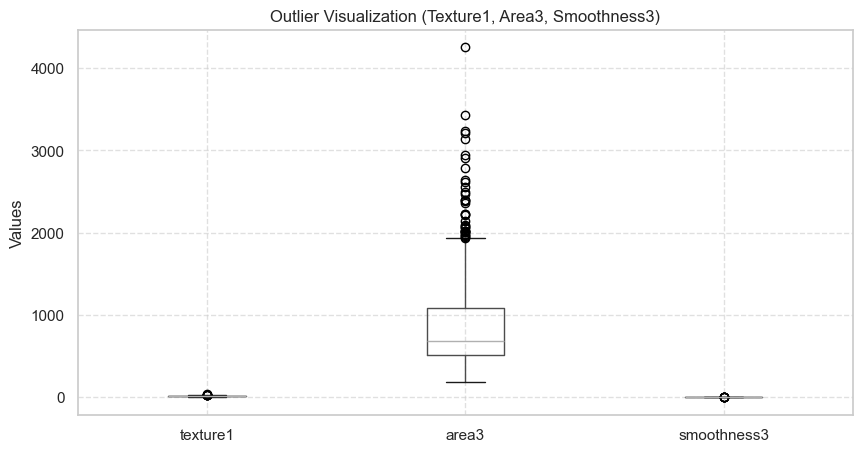

In [ ]:
# plptting the boxplot of the main columns

plt.figure(figsize=(10,5))
statistic_data.boxplot(column=features)
plt.title("Outlier Visualization (Texture1, Area3, Smoothness3)")
plt.ylabel("Values")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [62]:
data_shuffled = reduced_data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled['fold'] = np.arange(len(data_shuffled)) % 10

# If you want 80% of data for training
# training = data_shuffled[data_shuffled['fold'].isin([0,1,2,3,4,5,6,7])]